In [2]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings
import geopandas as gpd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import os
import country_converter as coco


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])


from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

# last dataset contains all other datasets (because of concat) 
all_features = features_df_list[-1]['data'].columns


country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data_views = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data_views.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        # check if actuals exist for the country
        if check_Actuals(country_id, 0):
            # check if the last feature month is 3 months before the first actuals month
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()

# concat all actual month ged_sb for each country
actuals_df_concat = pd.DataFrame()

for i in range(1,len(actuals_df_list)):
    if i == 1:
        actuals_df_concat = pd.concat([actuals_df_list[i-1]['data'], actuals_df_list[i]['data']])
    else:
        actuals_df_concat = pd.concat([actuals_df_concat, actuals_df_list[i]['data']])

actuals_df_concat_group = actuals_df_concat.groupby('country_id')


In [3]:
zero_fatalities_country_list = []
countries_with_low_conflict_list = []
countries_with_middle_conflict_list = []
countries_with_high_conflict_list = []

for country_id in country_list:
    actual_data_all_testwindows = actuals_df_concat_group.get_group(country_id)

    # Berechnen mittelwert ged_sb in allen testwindows
    mean_fatalities = np.mean(actual_data_all_testwindows['ged_sb'])

    if mean_fatalities == 0:
        zero_fatalities_country_list.append(country_id)
    elif mean_fatalities > 0 and mean_fatalities <= 5:
        countries_with_low_conflict_list.append(country_id)
    elif mean_fatalities > 5 and mean_fatalities <= 100:
        countries_with_middle_conflict_list.append(country_id)
    else:
        countries_with_high_conflict_list.append(country_id)

countries_with_high_conflict_list

[57, 79, 120, 124, 126, 133, 220]

In [4]:
dataset_to_oct17 = features_df_list

In [5]:
# keine Plots
# wie viele Länder mit Null, einteilung in low middle high und welche Länder -> Verteilung
# wie viele nullen prozentual im datensatz? x% in der gesamten spalte ged_sb ist 0 XXXXXX
# tabelle mit feature variablen

In [6]:
# Plots:
# - 4 testwindows summe der Todesfälle (low middle high all) -> Konfliktgeschehen der vier Vorhersagejahre linienplot über die Monate XXXXXXXXXXXXX
# - map mit dursch. todesfallzahl pro monat über die vier testwindows XXXXXXXXXX
# - Dichte der low middle und high countries (3 plots nebeneinander oder in einem plots zusammen) XXXXXXXXXXXXXXXXXXXXXX

# - cm dichte der fatalities für alle jahre 1990-2022 für monate > 0 (für alle länder die gefragt sind, low, middle, high) XXXXXXXXXXXXXXXXXXXXXXXXX
# (jeder einzelne monat eines landes ist ein wert) XXXXXXXXXXXXXX
# - Piechart XXXXXXXXXXXXXXXXX
# - plot overdispersion spezifische länder XXXXXXXXXXXXX

In [7]:
# ergebnis plots:
# - welches modell hat in jedem der vier testwindows in welchem land am besten funktioniert (crps ergebnisse plotten) -> vier plots map! XXXXXXXXXXXXXXXXX
# - mean crps map 2018 bis 2021 von NB var 2 XXXXXXXXXX

# Empirical Density of all Observations untill October 2017

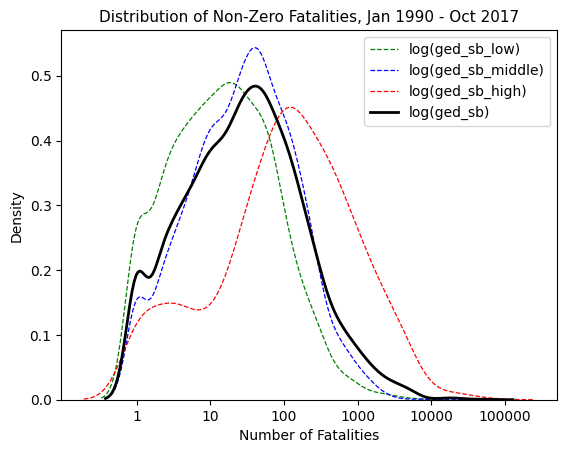

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log10

feature_data_oct_17 = features_df_list[0]['data']['ged_sb']

month_list = feature_data_oct_17.index.get_level_values('month_id').unique().to_list()

ged_sb_values_low = []
ged_sb_values_middle = []
ged_sb_values_high = []


for month in month_list:

    country_list_month = feature_data_oct_17.xs(month, level='month_id').index.get_level_values('country_id').unique().to_list()

    for country in country_list_month:
        if country in countries_with_low_conflict_list:
            ged_sb_values_low.append(feature_data_oct_17.xs((month,country)))
        elif country in countries_with_middle_conflict_list:
            ged_sb_values_middle.append(feature_data_oct_17.xs((month,country)))
        elif country in countries_with_high_conflict_list:
            ged_sb_values_high.append(feature_data_oct_17.xs((month,country)))


ged_sb_values = np.concatenate((ged_sb_values_low, ged_sb_values_middle, ged_sb_values_high))
ged_sb_values_low = np.array(ged_sb_values_low)
ged_sb_values_middle = np.array(ged_sb_values_middle)
ged_sb_values_high = np.array(ged_sb_values_high)

ged_sb_values_pos = ged_sb_values[ged_sb_values > 0]
ged_sb_values_low_pos = ged_sb_values_low[ged_sb_values_low > 0]
ged_sb_values_middle_pos = ged_sb_values_middle[ged_sb_values_middle > 0]
ged_sb_values_high_pos = ged_sb_values_high[ged_sb_values_high > 0]

ged_sb_values_log10 = log10(ged_sb_values_pos)
ged_sb_values_low_log10 = log10(ged_sb_values_low_pos)
ged_sb_values_middle_log10 = log10(ged_sb_values_middle_pos)
ged_sb_values_high_log10 = log10(ged_sb_values_high_pos)

# Erstelle ein KDE-Plot

sns.kdeplot(ged_sb_values_low_log10, fill=False, color='green', linewidth=0.9, linestyle='--', label='log(ged_sb_low)')
sns.kdeplot(ged_sb_values_middle_log10, fill=False, color='blue', linewidth=0.9, linestyle='--', label='log(ged_sb_middle)')
sns.kdeplot(ged_sb_values_high_log10, fill=False, color='red', linewidth=0.9, linestyle='--',label='log(ged_sb_high)')
sns.kdeplot(ged_sb_values_log10, fill=False, color='black', linewidth=2, label='log(ged_sb)')

custom_ticks = [0,1,2,3,4,5]
custom_labels = ['1','10','100','1000','10000','100000']
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Number of Fatalities')

plt.legend(loc='upper right')

plt.title('Distribution of Non-Zero Fatalities, Jan 1990 - Oct 2017', fontsize=11, y=1) # Benchmark  NB   Hurdle   Neural Net

# Zeige das Diagramm
plt.show()

# Piechart number of Zeros etc.

In [9]:
merged_array = np.concatenate((ged_sb_values_low, ged_sb_values_middle, ged_sb_values_high))

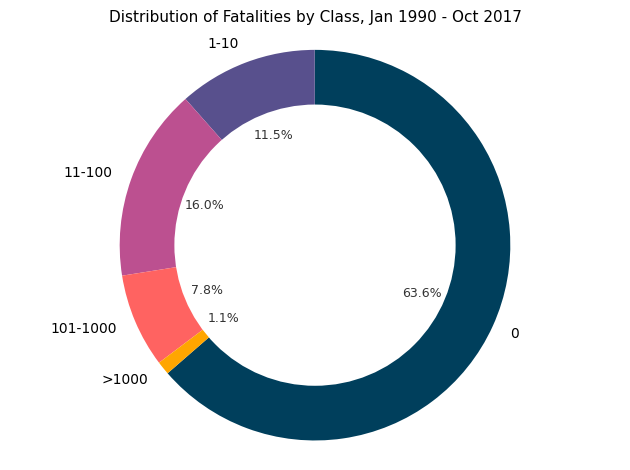

In [10]:
import matplotlib.pyplot as plt

# Beispielarray (ersetze dies durch dein eigenes Array)
data = merged_array

# Zähle die Anzahl der Elemente in jeder Klasse
class_0 = sum(1 for i in data if i == 0)
class_1_10 = sum(1 for i in data if 1 <= i <= 10)
class_11_100 = sum(1 for i in data if 11 <= i <= 100)
class_101_1000 = sum(1 for i in data if 101 <= i <= 1000)
class_gt_1000 = sum(1 for i in data if i > 1000)

# Berechne den prozentualen Anteil jeder Klasse
total_samples = len(data)
percent_class_0 = (class_0 / total_samples) * 100
percent_class_1_10 = (class_1_10 / total_samples) * 100
percent_class_11_100 = (class_11_100 / total_samples) * 100
percent_class_101_1000 = (class_101_1000 / total_samples) * 100
percent_class_gt_1000 = (class_gt_1000 / total_samples) * 100

# Erstelle das Pie-Chart
labels = ['0', '1-10', '11-100', '101-1000', '>1000']
sizes = [percent_class_0, percent_class_1_10, percent_class_11_100, percent_class_101_1000, percent_class_gt_1000]
colors = ['#003f5c','#58508d','#bc5090','#ff6361','#ffa600']


# Pie chart
fig1, ax1 = plt.subplots()
#ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=-139)

wedges, texts, autotexts = ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=-139)

for text in texts:
    text.set_fontsize(10)

for autotext in autotexts:
    autotext.set_fontsize(9)
    autotext.set_color('#333333')



#draw circle
centre_circle = plt.Circle((0,0),0.72,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  

plt.title('Distribution of Fatalities by Class, Jan 1990 - Oct 2017', fontsize=11, y=1) # Benchmark  NB   Hurdle   Neural Net

plt.tight_layout()
plt.show()


# Empirical Density of all Observations 2018-2021

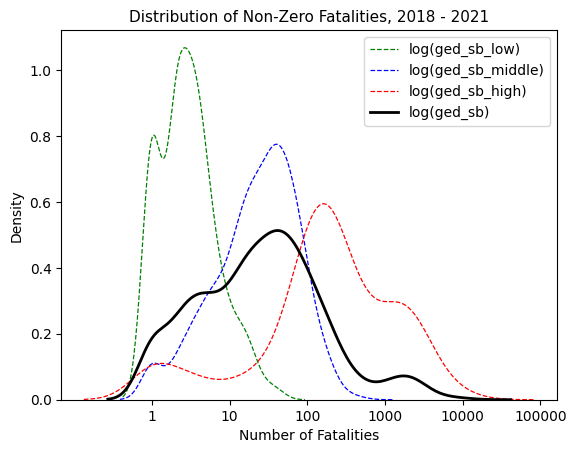

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import log10

actual_data_test_windows = actuals_df_concat['ged_sb']

month_list = actual_data_test_windows.index.get_level_values('month_id').unique().to_list()

ged_sb_values_low = []
ged_sb_values_middle = []
ged_sb_values_high = []


for month in month_list:

    country_list_month = actual_data_test_windows.xs(month, level='month_id').index.get_level_values('country_id').unique().to_list()

    for country in country_list_month:
        if country in countries_with_low_conflict_list:
            ged_sb_values_low.append(actual_data_test_windows.xs((month,country)))
        elif country in countries_with_middle_conflict_list:
            ged_sb_values_middle.append(actual_data_test_windows.xs((month,country)))
        elif country in countries_with_high_conflict_list:
            ged_sb_values_high.append(actual_data_test_windows.xs((month,country)))


ged_sb_values = np.concatenate((ged_sb_values_low, ged_sb_values_middle, ged_sb_values_high))
ged_sb_values_low = np.array(ged_sb_values_low)
ged_sb_values_middle = np.array(ged_sb_values_middle)
ged_sb_values_high = np.array(ged_sb_values_high)

ged_sb_values_pos = ged_sb_values[ged_sb_values > 0]
ged_sb_values_low_pos = ged_sb_values_low[ged_sb_values_low > 0]
ged_sb_values_middle_pos = ged_sb_values_middle[ged_sb_values_middle > 0]
ged_sb_values_high_pos = ged_sb_values_high[ged_sb_values_high > 0]

ged_sb_values_log10 = log10(ged_sb_values_pos)
ged_sb_values_low_log10 = log10(ged_sb_values_low_pos)
ged_sb_values_middle_log10 = log10(ged_sb_values_middle_pos)
ged_sb_values_high_log10 = log10(ged_sb_values_high_pos)

# Erstelle ein KDE-Plot

sns.kdeplot(ged_sb_values_low_log10, fill=False, color='green', linewidth=0.9, linestyle='--', label='log(ged_sb_low)')
sns.kdeplot(ged_sb_values_middle_log10, fill=False, color='blue', linewidth=0.9, linestyle='--', label='log(ged_sb_middle)')
sns.kdeplot(ged_sb_values_high_log10, fill=False, color='red', linewidth=0.9, linestyle='--',label='log(ged_sb_high)')
sns.kdeplot(ged_sb_values_log10, fill=False, color='black', linewidth=2, label='log(ged_sb)')

custom_ticks = [0,1,2,3,4,5]
custom_labels = ['1','10','100','1000','10000','100000']
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Number of Fatalities')

plt.legend(loc='upper right')

plt.title('Distribution of Non-Zero Fatalities, 2018 - 2021', fontsize=11, y=1) # Benchmark  NB   Hurdle   Neural Net

# Zeige das Diagramm
plt.show()

# Linechart actuals: all, low, middle, high

In [12]:
testwindow_months = actuals_df_concat.index.get_level_values('month_id').unique().to_list()

low_actuals_list = []
middle_actuals_list = []
high_actuals_list = []
all_actuals_list = []

for month in testwindow_months:
    low = []
    middle = []
    high = []
    all = []
    for country in country_list:
        all.append(actuals_df_concat_group.get_group(country).xs(month,level='month_id').iloc[0,0])

        if country in countries_with_low_conflict_list:
            low.append(actuals_df_concat_group.get_group(country).xs(month,level='month_id').iloc[0,0])
        elif country in countries_with_middle_conflict_list:
            middle.append(actuals_df_concat_group.get_group(country).xs(month,level='month_id').iloc[0,0])
        elif country in countries_with_high_conflict_list:
            high.append(actuals_df_concat_group.get_group(country).xs(month,level='month_id').iloc[0,0])

    all_actuals_list.append(np.sum(all))
    low_actuals_list.append(np.sum(low))
    middle_actuals_list.append(np.sum(middle))
    high_actuals_list.append(np.sum(high))

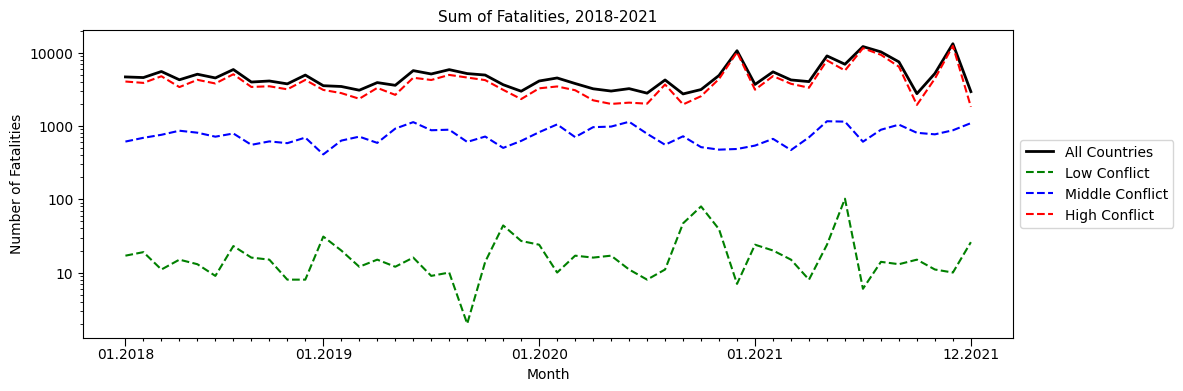

In [13]:
plt.figure(figsize=(12, 4))

# Erzeuge das Liniendiagramm
plt.plot(testwindow_months, all_actuals_list, color='black', linewidth=2, label='All Countries')
plt.plot(testwindow_months, low_actuals_list, color='green',linewidth=1.5, linestyle='--', label='Low Conflict')
plt.plot(testwindow_months, middle_actuals_list, color='blue',linewidth=1.5, linestyle='--', label='Middle Conflict')
plt.plot(testwindow_months, high_actuals_list, color='red',linewidth=1.5, linestyle='--', label='High Conflict')

plt.yscale('log')

no_label_string = ['']*11

custom_ticks = testwindow_months
custom_labels = []
january = ['01.2018','01.2019','01.2020','01.2021','12.2021']
january_list = [0,11,23,35,47]
j = 0
for i in range(len(testwindow_months)):
    if i in january_list: 
        custom_labels.append(january[j])
        j += 1
    else:
        custom_labels.append('')

plt.xticks(custom_ticks, custom_labels)

# Mache bestimmte Ticks dicker
for i, tick in enumerate(plt.gca().xaxis.get_major_ticks()):
    if i in january_list:
        #tick.label1.set_fontsize(14)  # Setze die Dicke der gewünschten Ticks
        tick.tick1line.set_markersize(6)  # Ändert die Länge der Ticks
        tick.label1.set_verticalalignment('top')
    else:
        tick.tick1line.set_markersize(2) 

custom_y_ticks = [10,100,1000,10000]
custom_y_labels = ['10', '100', '1000', '10000']
plt.yticks(custom_y_ticks,custom_y_labels)

plt.xlabel('Month')
plt.ylabel('Number of Fatalities')

plt.title('Sum of Fatalities, 2018-2021', fontsize=11, y=1) # Benchmark  NB   Hurdle   Neural Net
# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Zeige das Diagramm
plt.show()

# Average number of fatalities in the test windows: geomap

In [14]:
data = {'country_id': [], 'mean_ged_sb_tw': []}
df_mean_ged_perCtr = pd.DataFrame(data)

# fill dataframe
for country_id in country_list:
    mean_ged_sb = np.mean(actuals_df_concat_group.get_group(country_id))

    df_mean_ged_perCtr.loc[len(df_mean_ged_perCtr)] = [country_id, mean_ged_sb]


iso_2_codes_list = ['GY', 'SR', 'TT', 'VE', 'WS', 'TO', 'AR', 'BO', 'BR', 'CL', 'EC', 'PY', 'PE', 'UY', 'GT', 'MX', 'BB', 'DM', 'GD', 'LC', 'VC', 'DO', 'HT', 'JM', 'BS', 'BZ', 'CO', 'CR', 'CU', 'SV', 'HN', 'NI', 'PA', 'AG', 'KN', 'IS', 'IE', 'GB', 'CV', 'CI', 'GH', 'LR', 'PT', 'ES', 'BF', 'GN', 'GW', 'ML', 'SN', 'SL', 'GM', 'DJ', 'ER', 'ET', 'MN', 'IQ', 'JO', 'KZ', 'NO', 'RU', 'SE', 'DZ', 'CM', 'CF', 'TN', 'BJ', 'GQ', 'KI', 'NE', 'NG', 'ST', 'TG', 'AL', 'BA', 'HR', 'IT', 'MK', 'MT', 'BG', 'CY', 'GE', 'GR', 'LB', 'TR', 'AT', 'CZ', 'DK', 'HU', 'PL', 'SK', 'SI', 'BE', 'FR', 'LU', 'NL', 'CH', 'BY', 'EE', 'FI', 'LV', 'LT', 'MD', 'RO', 'UA', 'MV', 'OM', 'SO', 'LK', 'TM', 'UZ', 'YE', 'AM', 'AZ', 'BH', 'IR', 'KW', 'QA', 'SA', 'AE', 'AF', 'KG', 'NP', 'PK', 'TJ', 'BD', 'BT', 'BN', 'JP', 'KP', 'PW', 'PH', 'KR', 'KH', 'LA', 'MM', 'TH', 'VN', 'MH', 'FM', 'BW', 'BI', 'RW', 'ZM', 'ZW', 'KM', 'LS', 'MW', 'MZ', 'ZA', 'SZ', 'AO', 'CG', 'CD', 'FJ', 'GA', 'NA', 'NZ', 'MG', 'MU', 'SC', 'TL', 'AU', 'NR', 'PG', 'SB', 'TV', 'VU', 'CA', 'DE', 'TW', 'CN', 'MY', 'SG', 'ID', 'LY', 'TD', 'IL', 'SY', 'EG', 'IN', 'ME', 'XK', 'RS', 'US', 'UG', 'KE', 'TZ', 'MA', 'MR', 'SD', 'SS']
#country_code = ['GUY', 'SUR', 'TTO', 'VEN', 'WSM', 'TON', 'ARG', 'BOL', 'BRA', 'CHL', 'ECU', 'PRY', 'PER', 'URY', 'GTM', 'MEX', 'BRB', 'DMA', 'GRD', 'LCA', 'VCT', 'DOM', 'HTI', 'JAM', 'BHS', 'BLZ', 'COL', 'CRI', 'CUB', 'SLV', 'HND', 'NIC', 'PAN', 'ATG', 'KNA', 'ISL', 'IRL', 'GBR', 'CPV', 'CIV', 'GHA', 'LBR', 'PRT', 'ESP', 'BFA', 'GIN', 'GNB', 'MLI', 'SEN', 'SLE', 'GMB', 'DJI', 'ERI', 'ETH', 'MNG', 'IRQ', 'JOR', 'KAZ', 'NOR', 'RUS', 'SWE', 'DZA', 'CMR', 'CAF', 'TUN', 'BEN', 'GNQ', 'KIR', 'NER', 'NGA', 'STP', 'TGO', 'ALB', 'BIH', 'HRV', 'ITA', 'MKD', 'MLT', 'BGR', 'CYP', 'GEO', 'GRC', 'LBN', 'TUR', 'AUT', 'CZE', 'DNK', 'HUN', 'POL', 'SVK', 'SVN', 'BEL', 'FRA', 'LUX', 'NLD', 'CHE', 'BLR', 'EST', 'FIN', 'LVA', 'LTU', 'MDA', 'ROU', 'UKR', 'MDV', 'OMN', 'SOM', 'LKA', 'TKM', 'UZB', 'YEM', 'ARM', 'AZE', 'BHR', 'IRN', 'KWT', 'QAT', 'SAU', 'ARE', 'AFG', 'KGZ', 'NPL', 'PAK', 'TJK', 'BGD', 'BTN', 'BRN', 'JPN', 'PRK', 'PLW', 'PHL', 'KOR', 'KHM', 'LAO', 'MMR', 'THA', 'VNM', 'MHL', 'FSM', 'BWA', 'BDI', 'RWA', 'ZMB', 'ZWE', 'COM', 'LSO', 'MWI', 'MOZ', 'ZAF', 'SWZ', 'AGO', 'COG', 'COD', 'FJI', 'GAB', 'NAM', 'NZL', 'MDG', 'MUS', 'SYC', 'TLS', 'AUS', 'NRU', 'PNG', 'SLB', 'TUV', 'VUT', 'CAN', 'DEU', 'TWN', 'CHN', 'MYS', 'SGP', 'IDN', 'LBY', 'TCD', 'ISR', 'SYR', 'EGY', 'IND', 'MNE', 'KOS', 'SRB', 'USA', 'UGA', 'KEN', 'TZA', 'MAR', 'MRT', 'SDN', 'SDS']

data_to_plot = df_mean_ged_perCtr

#data_to_plot['country_code'] = country_code
data_to_plot['code'] = iso_2_codes_list

pd.options.display.max_rows = 0
#data_to_plot

In [15]:
relative_path_shapefile = os.path.join('..', 'plots_model_comp','ne_10m_admin_0_countries', 'ne_10m_admin_0_countries.shp')
SHAPEFILE = os.path.join(current_dir, relative_path_shapefile)


# Read shapefile using Geopandas
geo_df = gpd.read_file(SHAPEFILE)[['ADMIN', 'ADM0_A3', 'geometry']]

# Rename columns.
geo_df.columns = ['country', 'country_code', 'geometry']
geo_df.head(3)

# Drop row for 'Antarctica'. It takes a lot of space in the map and is not of much use
geo_df = geo_df.drop(geo_df.loc[geo_df['country'] == 'Antarctica'].index)

# Next, we need to ensure that our data matches with the country codes. 
iso3_codes = geo_df['country'].to_list()
# Convert to iso3_codes
iso2_codes_list = coco.convert(names=iso3_codes, to='ISO2', not_found='NULL')
# Add the list with iso2 codes to the dataframe
geo_df['iso2_code'] = iso2_codes_list
# There are some countries for which the converter could not find a country code. 
# We will drop these countries.
geo_df = geo_df.drop(geo_df.loc[geo_df['iso2_code'] == 'NULL'].index)


Dhekelia Sovereign Base Area not found in regex
US Naval Base Guantanamo Bay not found in regex
Siachen Glacier not found in regex
Baykonur Cosmodrome not found in regex
Akrotiri Sovereign Base Area not found in regex
Southern Patagonian Ice Field not found in regex
Bir Tawil not found in regex
Indian Ocean Territories not found in regex
Coral Sea Islands not found in regex
Spratly Islands not found in regex
Clipperton Island not found in regex
Ashmore and Cartier Islands not found in regex
Bajo Nuevo Bank (Petrel Is.) not found in regex
Serranilla Bank not found in regex
Scarborough Reef not found in regex


In [16]:
merged_df = pd.merge(left=geo_df, right=data_to_plot, how='right', left_on='iso2_code', right_on='code')
df = merged_df.drop(['code'], axis=1)

In [17]:
""" # Print the map
# Set the range for the choropleth
from numpy import log10

title = 'Fatalities in Month 504 (Dec. 2022)'

df['log10_ged_sb'] = log10(df['ged_sb']+1)

col = 'log10_ged_sb'
vmin = df[col].min()
vmax = df[col].max()
cmap = 'viridis'
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
# Add a title
ax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})
# Create an annotation for the data source
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])

# Setzen Sie die Farbskala
cbar = fig.colorbar(sm, cax=cbaxes)


# Überschreiben der Legendenbeschriftungen
new_labels = ['0', '3', '10', '30', '100', '300', '1000']
cbar.ax.set_yticklabels(new_labels) """

" # Print the map\n# Set the range for the choropleth\nfrom numpy import log10\n\ntitle = 'Fatalities in Month 504 (Dec. 2022)'\n\ndf['log10_ged_sb'] = log10(df['ged_sb']+1)\n\ncol = 'log10_ged_sb'\nvmin = df[col].min()\nvmax = df[col].max()\ncmap = 'viridis'\n# Create figure and axes for Matplotlib\nfig, ax = plt.subplots(1, figsize=(20, 8))\n# Remove the axis\nax.axis('off')\ndf.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)\n# Add a title\nax.set_title(title, fontdict={'fontsize': '25', 'fontweight': '3'})\n# Create an annotation for the data source\n            \n# Create colorbar as a legend\nsm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)\n# Empty array for the data range\nsm._A = []\n# Add the colorbar to the figure\ncbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])\n\n# Setzen Sie die Farbskala\ncbar = fig.colorbar(sm, cax=cbaxes)\n\n\n# Überschreiben der Legendenbeschriftungen\nnew_labels = ['0', '3', '10', '30', '100', '300', '10

[Text(1, 0.0, '0'),
 Text(1, 0.6020599913279624, '3'),
 Text(1, 1.0413926851582251, '10'),
 Text(1, 1.4913616938342726, '30'),
 Text(1, 2.0043213737826426, '100'),
 Text(1, 2.4785664955938436, '300'),
 Text(1, 3.000434077479319, '1000'),
 Text(1, 3.367817773386549, '2331')]

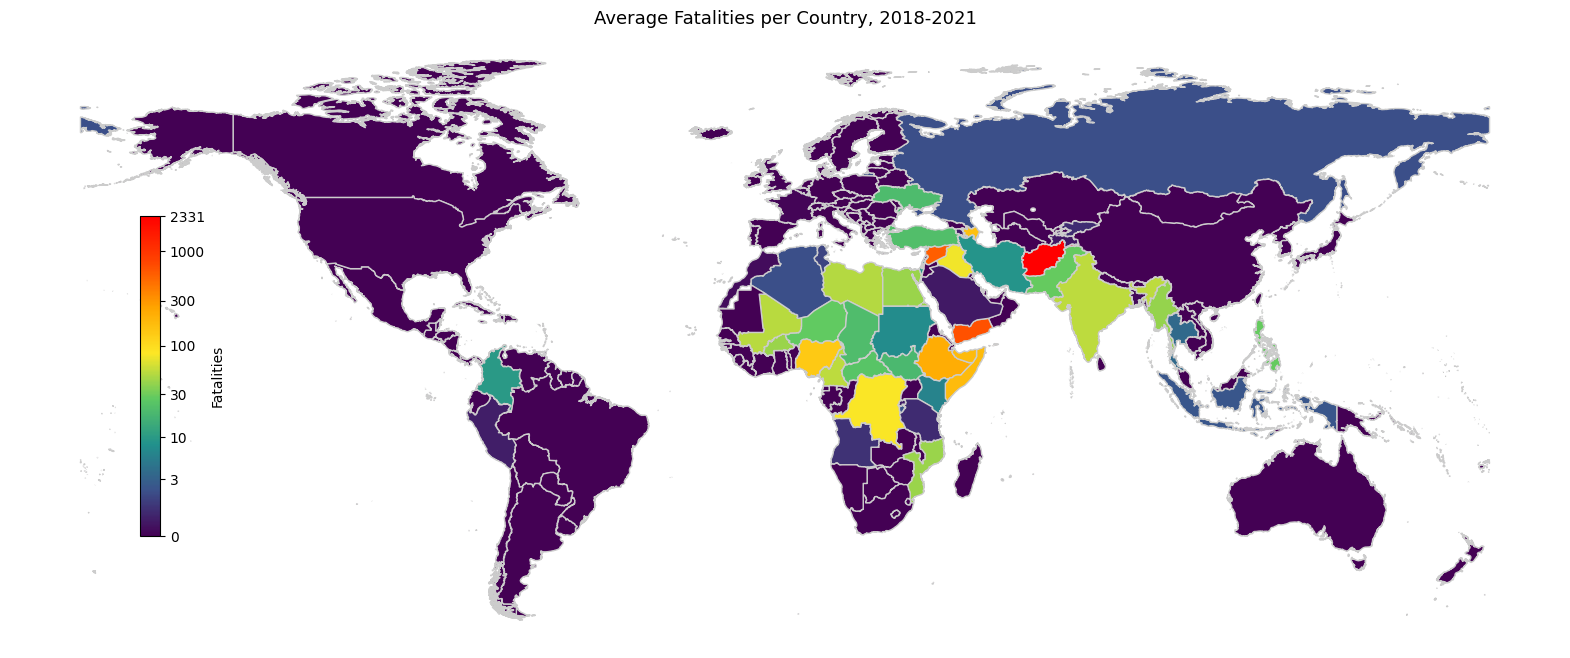

In [18]:
# Print the map
# Set the range for the choropleth
from numpy import log10
import matplotlib.colors as mcolors

title = 'Average Fatalities per Country, 2018-2021'

df['log10_ged_sb'] = log10(df['mean_ged_sb_tw']+1)

col = 'log10_ged_sb'
vmin = df[col].min()
vmax = df[col].max()

colors = ['#440154', '#3b528b', '#21918c', '#5ec962', '#fde725', '#FFA500', '#FF4500', '#FF0000']

cmap = mcolors.LinearSegmentedColormap.from_list('custom', colors)
# Create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(20, 8))
# Remove the axis
ax.axis('off')
df.plot(column=col, ax=ax, edgecolor='0.8', linewidth=1, cmap=cmap)
# Add a title
ax.set_title(title, fontdict={'fontsize': '13', 'fontweight': '2'})
# Create an annotation for the data source
            
# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap=cmap)
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([0.19, 0.25, 0.01, 0.4])
#cbaxes = fig.add_axes([0.87, 0.25, 0.01, 0.4])

ticks = [log10(0 + 1), log10(3 + 1),log10(10 + 1),log10(30 + 1),log10(100 + 1),log10(300 + 1),log10(1000 + 1),vmax]

# Setzen Sie die Farbskala
cbar = fig.colorbar(sm, cax=cbaxes, ticks=ticks)
cbar.set_label('Fatalities', fontsize=10)


# Überschreiben der Legendenbeschriftungen
new_labels = ['0', '3', '10', '30', '100', '300', '1000',str(round(10**vmax - 1))]
cbar.ax.set_yticklabels(new_labels)